<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/7_22_%EB%AA%A9_news_group20(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

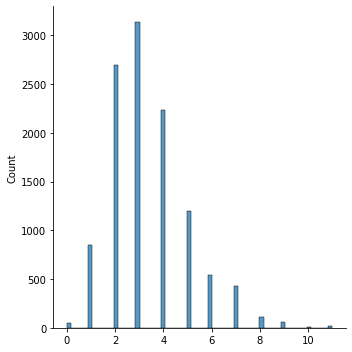

((9051, 6), (9051, 1), (2263, 6), (2263, 1))

In [ ]:
# -*- coding: utf-8 -*-
"""news_group20(LSTM).ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1x94rt9mvcG9NZjg-gUMkxakeKho5uPpT
"""

# Commented out IPython magic to ensure Python compatibility.
# LSTM으로 subject를 clasification한다.
# ------------------------------------
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# %cd '/content/drive/MyDrive/Colab Notebooks'

# 전처리가 완료된 한글 코퍼스를 읽어온다.
with open('/content/drive/MyDrive/Colab Notebooks/pickle/newsgroup20.pkl', 'rb') as f:
    subject, text, topic = pickle.load(f)

n_topic = len(set(topic)) # 0 ~ 19 개의 토픽

max_word = 5000
tokenizer = Tokenizer(num_words = max_word, oov_token = '<OOV>')
tokenizer.fit_on_texts(subject)
sent_idx = tokenizer.texts_to_sequences(subject)  # sent에 idx 부여
word2idx = {k:v for (k, v) in list(tokenizer.word_index.items())[:max_word]}
word2idx['<PAD>'] = 0
idx2word = {v:k for (k, v) in word2idx.items()}

# subject을 길이 분포를 확인한다.
n_len = [len(sub) for sub in sent_idx]
sns.displot(n_len)
plt.show()

# 문장의 길이를 6으로 맞춘다.
x_data = pad_sequences(sent_idx, maxlen=6, padding='post', truncating='post')
y_data = topic

# 학습 데이터와 시험데이터로 분리한다.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


In [ ]:

# LSTM 모델을 생성한다.
EMB_SIZE = 32
VOCAB_SIZE = len(word2idx) + 1
x_input = Input(batch_shape = (None, x_train.shape[1]))
x_embed = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(x_input)
x_embed = Dropout(0.5)(x_embed)
x_lstm = LSTM(64, dropout=0.5)(x_embed)
y_output = Dense(n_topic, activation = 'softmax')(x_lstm)

model = Model(x_input, y_output)     # 학습, 예측용 모델
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.01))
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 6, 32)             160064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1300      
Total params: 186,196
Trainable params: 186,196
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델을 학습한다.
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 512, epochs = 30)


Epoch 1/30
18/18 [==============================] - 3s 63ms/step - loss: 2.8293 - val_loss: 2.2246
Epoch 2/30
18/18 [==============================] - 1s 43ms/step - loss: 1.9125 - val_loss: 1.3879
Epoch 3/30
18/18 [==============================] - 1s 39ms/step - loss: 1.3794 - val_loss: 1.0315
Epoch 4/30
18/18 [==============================] - 1s 40ms/step - loss: 1.0955 - val_loss: 0.8971
Epoch 5/30
18/18 [==============================] - 1s 40ms/step - loss: 0.9454 - val_loss: 0.7909
Epoch 6/30
18/18 [==============================] - 1s 40ms/step - loss: 0.8365 - val_loss: 0.7244
Epoch 7/30
18/18 [==============================] - 1s 40ms/step - loss: 0.7449 - val_loss: 0.7109
Epoch 8/30
18/18 [==============================] - 1s 41ms/step - loss: 0.6952 - val_loss: 0.6854
Epoch 9/30
18/18 [==============================] - 1s 40ms/step - loss: 0.6525 - val_loss: 0.6698
Epoch 10/30
18/18 [==============================] - 1s 39ms/step - loss: 0.6100 - val_loss: 0.6791
Epoch 11/

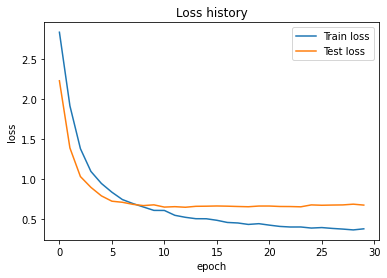

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1).reshape(-1, 1)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))



Accuracy = 83.52 %


In [ ]:
# 잘못 분류된 subject들을 살펴본다. 어떤 특징을 발견할 수 있을까?
mis_idx = [list(x_test[m]) for m in np.where(y_pred != y_test)[0]]

mis_sent = []
for sent in mis_idx:
    tmp = []
    for i in sent:
        if i > 0:      # pad가 아니면
            tmp.append(idx2word[i])
    mis_sent.append(tmp)
mis_sent[:10]


[[],
 ['espn', 'suck', 'basebal', 'guess'],
 ['ram', 'upgrad', 'slow'],
 ['year', 'say', 'christian', 'moral'],
 ['bounc', 'lymenet', 'newslett'],
 ['go'],
 ['crt', 'driver', 'transistor'],
 ['market', 'cruis', 'control', 'specif', 'question'],
 ['need', 'video', 'driver', 'tseng', 'true', 'color'],
 ['ati', 'ultra', 'pro', 'bit', 'window', 'driver']]

In [ ]:
# 잘못 분류된 subject들을 살펴본다. 어떤 특징을 발견할 수 있을까?
good_idx = [list(x_test[m]) for m in np.where(y_pred == y_test)[0]]

good_sent = []
for sent in good_idx:
    tmp = []
    for i in sent:
        if i > 0:      # pad가 아니면
            tmp.append(idx2word[i])
    good_sent.append(tmp)
good_sent[:10]

[['shelf', 'cheap', 'de', 'keyseach', 'machin', 'corpor'],
 ['govern', 'help'],
 ['memori', 'upgrad'],
 ['ati', 'ultra', 'pro', 'driver'],
 ['iisi', 'clock', 'upgrad'],
 ['vesa', 'graphic', 'standard'],
 ['societ', 'accept', 'behavior'],
 ['get', 'monitor'],
 ['diamond', 'stealth', 'give', 'winmark'],
 ['fast']]

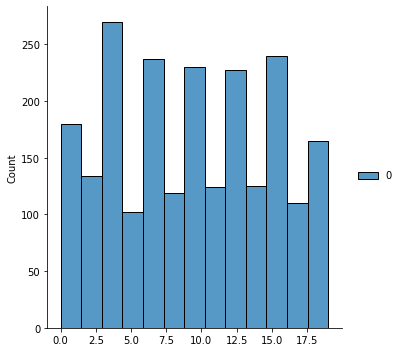

In [ ]:
sns.displot(y_pred)
plt.show()

